In [15]:
import pandas as pd
import geopandas as gpd
import bokeh
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.plotting import figure, show
from shapely.geometry import Point
from dateutil.parser import parse
import matplotlib.pyplot as plt
import requests
from requests.exceptions import Timeout
import json
from collections import defaultdict


# Read in csv (downloaded from Cambridge's Open Data Portal)
df = pd.read_csv('seeclickfix.csv')

In [2]:
# Get a list of all icy or unshoveled sidewalks created since 12/01/19
df.head()
snowy = df[df['issue_type'] == 'Icy or Unshoveled Sidewalk']

# Turn into a geopandas dataframe
geometry = [Point(xy) for xy in zip(snowy.lng, df.lat)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(snowy, crs=crs, geometry=geometry)

# Turn the created and closed dates into datetime objects
gdf = gdf.assign(ticket_created_date_time=gdf['ticket_created_date_time'].map(lambda x: parse(x)))
#gdf['ticket_closed_date_time'] = gdf['ticket_closed_date_time'].map(lambda x: parse(x))

gdf = gdf[gdf['ticket_created_date_time'] > parse('12/1/2019')]
gdf.head()

still_open = gdf[gdf['ticket_closed_date_time'].isna()]
closed = gdf[gdf['ticket_closed_date_time'].notna()]

print(still_open.shape)
print(closed.shape)
#still_open.sha
gdf.shape


closed = closed.assign(ticket_closed_date_time=closed['ticket_closed_date_time'].map(lambda x: parse(x)))
closed = closed.assign(days_open= closed['ticket_closed_date_time'] - closed['ticket_created_date_time'])

#df.assign(temp_f=df['temp_c'] * 9 / 5 + 32)
closed['days_open'] = closed['days_open'].apply(lambda x: pd.Timedelta.round(x, 'd').days)
closed.head()

#pd.Timedelta.round(closed.iloc[0]['days_open'], 'd')

(2, 14)
(522, 14)


,ticket_id,city,issue_type,ticket_status,issue_description,ticket_closed_date_time,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,geometry,days_open
2154,7118536,Cambridge,Icy or Unshoveled Sidewalk,closed,214 Walden,2019-12-21 13:39:35,2019-12-19 20:40:05,12/21/2019 01:39:35 PM,"214 Walden St Cambridge 02140, United States",42.386588,-71.129598,"(42.3865878277, -71.1295982018)",https://seeclickfix.com/files/issue_images/015...,POINT (-71.12959820182721 42.383453),2
2217,7120883,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,2019-12-21 13:29:38,2019-12-20 09:28:54,12/21/2019 01:29:38 PM,"12 Carlisle St Cambridge, MA, 02139, USA",42.372252,-71.098119,"(42.372252, -71.098119)",NaN,POINT (-71.098119 42.3725417),1
4270,7120629,Cambridge,Icy or Unshoveled Sidewalk,closed,consistently unshoveled and icy sidewalk,2019-12-21 13:34:18,2019-12-20 08:44:09,12/21/2019 01:34:18 PM,"117 Fayerweather St Cambridge, MA, 02138, USA",42.383421,-71.137012,"(42.383421, -71.1370125)",NaN,POINT (-71.1370125 42.368312),1
6023,7117375,Cambridge,Icy or Unshoveled Sidewalk,closed,icy sidewalk,2019-12-21 13:49:47,2019-12-19 13:58:48,12/21/2019 01:49:47 PM,"20 Berkeley St Cambridge, MA, 02138, USA",42.378453,-71.126190,"(42.378453, -71.12619)",NaN,POINT (-71.12618999999999 42.3874555),2
6959,7121112,Cambridge,Icy or Unshoveled Sidewalk,closed,Regularly unshoveled here,2019-12-21 13:32:53,2019-12-20 10:14:57,12/21/2019 01:32:53 PM,"3 Craigie St Cambridge, MA, 02138, USA",42.379317,-71.126667,"(42.379317, -71.126667)",NaN,POINT (-71.126667 42.3560005),1


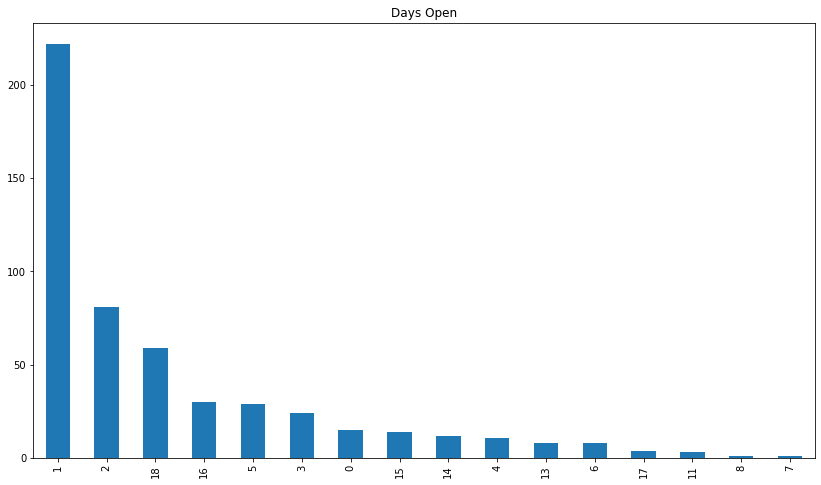

In [3]:
ax = closed['days_open'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Days Open")

In [4]:
closed[closed['days_open'] == 0]

,ticket_id,city,issue_type,ticket_status,issue_description,ticket_closed_date_time,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,geometry,days_open
44330,7043432,Cambridge,Icy or Unshoveled Sidewalk,closed,Every winter it never fails that the property ...,2019-12-03 01:59:16,2019-12-02 14:18:54,12/03/2019 01:59:16 AM,"29 Follen St Cambridge, MA, 02138, USA",42.379101,-71.121069,"(42.379101, -71.121069)",https://seeclickfix.com/files/issue_images/015...,POINT (-71.12106900000002 42.3688391),0
44336,7043690,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,2019-12-03 01:56:28,2019-12-02 15:06:35,12/03/2019 01:56:28 AM,"2443 Massachusetts Ave Cambridge, MA, 02140, USA",42.398092,-71.130853,"(42.3980916667, -71.1308527778)",https://seeclickfix.com/files/issue_images/015...,POINT (-71.13085277777782 42.3757078),0
44342,7044010,Cambridge,Icy or Unshoveled Sidewalk,closed,The sidewalk alongside the Alden Playground ou...,2019-12-03 01:54:17,2019-12-02 16:10:23,12/03/2019 01:54:17 AM,Cambridge 02138 United States,42.382832,-71.116233,"(42.3828322827, -71.1162327793)",https://seeclickfix.com/files/issue_images/015...,POINT (-71.11623277929741 42.3750139),0
44355,7047832,Cambridge,Icy or Unshoveled Sidewalk,closed,Warren Pearson called to request that the s/w ...,2019-12-03 09:57:04,2019-12-03 09:41:27,12/03/2019 09:57:04 AM,"O'Connell Branch Library 48 6th St, Cambridge,...",42.370460,-71.084900,"(42.37046, -71.0849)",NaN,POINT (-71.08489999999991 42.4005793),0
44357,7047895,Cambridge,Icy or Unshoveled Sidewalk,closed,Management has made no attempt to do any snow ...,2019-12-03 09:57:46,2019-12-03 09:48:53,12/03/2019 09:57:46 AM,"54 Bay State Rd Cambridge, MA 02138, USA",42.387215,-71.139290,"(42.3872146606, -71.139289856)",https://seeclickfix.com/files/issue_images/015...,POINT (-71.139289855957 42.391370516103),0
44366,7048805,Cambridge,Icy or Unshoveled Sidewalk,closed,The entire school has not been shoveled and th...,2019-12-03 12:31:04,2019-12-03 12:24:28,12/03/2019 12:31:04 PM,"70 Rindge Ave Cambridge 02140, United States",42.392800,-71.128386,"(42.3928, -71.12838617)",https://seeclickfix.com/files/issue_images/015...,POINT (-71.12838617 42.3700303),0
44367,7048884,Cambridge,Icy or Unshoveled Sidewalk,closed,icy sidewalk from 1910 all the way to MBTA pro...,2019-12-03 13:06:34,2019-12-03 12:44:13,12/03/2019 01:06:34 PM,"1910 Massachusetts Ave Cambridge, MA 02140, USA",42.388931,-71.119957,"(42.3889307, -71.1199567)",https://seeclickfix.com/files/issue_images/015...,POINT (-71.1199567 42.3851828),0
44372,7049527,Cambridge,Icy or Unshoveled Sidewalk,closed,NaN,2019-12-03 14:40:54,2019-12-03 14:33:10,12/03/2019 02:40:54 PM,"26 Columbia St Cambridge 02139, United States",42.363984,-71.099316,"(42.3639839824, -71.0993158321)",NaN,POINT (-71.09931583214959 42.3925437927246),0
44544,7060829,Cambridge,Icy or Unshoveled Sidewalk,closed,The walk way in the Cambridge Common frequentl...,2019-12-05 13:02:15,2019-12-05 12:46:00,12/05/2019 01:02:15 PM,"Cambridge Common 1500 Massachusetts Ave, Cambr...",42.376780,-71.120900,"(42.37678, -71.1209)",NaN,POINT (-71.12089999999991 42.3750065),0
44625,7067804,Cambridge,Icy or Unshoveled Sidewalk,closed,Icy sidewalk adjacent to the driveway on Tuesd...,2019-12-06 21:21:13,2019-12-06 21:17:34,12/06/2019 09:21:13 PM,"62 Putnam Ave Cambridge, MA, 02139, USA",42.368166,-71.113333,"(42.368166, -71.1133335)",NaN,POINT (-71.1133335 42.3912933),0


In [17]:
# Read cached comment data
with open('see_click_fix_comments.json') as json_file:
    comments = json.load(json_file)

def get_resolution(ticket_id, closed_time):

    for comment in comments[str(ticket_id)]:
        dt = parse(comment['created_at'])
        # Look for comments matching ticket closed time
        if dt.strftime("%m/%d/%Y, %H:%M:%S") == closed_time.strftime("%m/%d/%Y, %H:%M:%S"):
            if 'citation was issued' in comment['comment']:
                return 'citation'
            elif 'pleased' in comment['comment'] and 'resolved' in comment['comment']:
                return 'resolved'
            elif 'new snow operation' in comment['comment']:
                return 'new_snow'
            # These should probably be filtered out of the total
            elif 'we are still in an snow operation' in comment['comment']:
                return 'still_snowing'
            elif 'large number of reports' in comment['comment'] and 'now in compliance' in comment['comment']:
                return 'delayed_inspection'
            elif 'found to be in compliance' in comment['comment']:
                return 'in_compliance'
            else:
                print(ticket_id)
            

resolutions = defaultdict(int)
for index, row in closed.iterrows():
    resolution = get_resolution(row['ticket_id'], row['ticket_closed_date_time'])
    resolutions[resolution] += 1

print(resolutions)

7048805
7049527
7053190
7053259
7053540
7054679
7054924
7055674
7060574
7061077
7066552
7066639
7067629
7067804
7053531
7108864
7111071
7112238
7056370
7056504
7084494
7064787
7064810
7064953
7117730
7113335
defaultdict(<class 'int'>, {'delayed_inspection': 161, 'citation': 190, 'in_compliance': 43, 'new_snow': 10, None: 61, 'still_snowing': 1, 'resolved': 56})


In [ ]:
p = figure(x_range=(-7919969.67, -7911590.87), y_range=(5221575.24, 5214113.74), x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)
show(p)

#coords = [[-9759284.802320646, -9759781.18], [5139718.458609748, 5162158.11]]    
#p.line(x=coords[0], y=coords[1])